In [1]:
%cd ../

/Users/yasmin/paper/FederatedLearning


In [1]:
import warnings
warnings.simplefilter('ignore')

## Stochastic Block Model Experiment

Before geting into the experiment details, let's review algorithm 1 and the primal and dual updates.

### Algorithm 1

![title](../algorithm1.png)

In [2]:
# %load algorithm/main.py
from sklearn.metrics import mean_squared_error

# from algorithm.penalty import *


def algorithm_1(K, D, weight_vec, datapoints, true_labels, samplingset, lambda_lasso, penalty_func_name='norm1', calculate_score=False):
    '''
    :param K: the number of iterations
    :param D: the block incidence matrix
    :param weight_vec: a list containing the edges's weights of the graph
    :param datapoints: a dictionary containing the data of each node in the graph needed for the algorithm 1
    :param true_labels: a list containing the true labels of the nodes
    :param samplingset: the sampling set
    :param lambda_lasso: the parameter lambda
    :param penalty_func_name: the name of the penalty function used in the algorithm

    :return iteration_scores: the mean squared error of the predicted weight vectors in each iteration
    :return new_w: the predicted weigh vectors for each node
    '''

    Sigma = np.diag(np.full(weight_vec.shape, 0.9 / 2))
    '''
    Sigma: the block diagonal matrix Sigma
    '''
    T_matrix = np.diag(np.array((1.0 / (np.sum(abs(D), 0)))).ravel())
    '''
    T_matrix: the block diagonal matrix T
    '''

    if np.linalg.norm(np.dot(Sigma ** 0.5, D).dot(T_matrix ** 0.5), 2) > 1:
        print ('product norm', np.linalg.norm(np.dot(Sigma ** 0.5, D).dot(T_matrix ** 0.5), 2))

    E, N = D.shape
    m, n = datapoints[0]['features'].shape

    # define the penalty function
    if penalty_func_name == 'norm1':
        penalty_func = Norm1Pelanty(lambda_lasso, weight_vec, Sigma, n)

    elif penalty_func_name == 'norm2':
        penalty_func = Norm2Pelanty(lambda_lasso, weight_vec, Sigma, n)

    elif penalty_func_name == 'mocha':
        penalty_func = MOCHAPelanty(lambda_lasso, weight_vec, Sigma, n)

    else:
        raise Exception('Invalid penalty name')

    # starting algorithm 1

    new_w = np.array([np.zeros(n) for i in range(N)])
    '''
    new_w: the primal variable of the algorithm 1
    '''
    new_u = np.array([np.zeros(n) for i in range(E)])
    '''
    new_u: the dual variable of the algorithm 1
    '''

    iteration_scores = []
    for iterk in range(K):
        # if iterk % 100 == 0:
        #     print ('iter:', iterk)
        prev_w = np.copy(new_w)

        # algorithm 1, line 2
        hat_w = new_w - np.dot(T_matrix, np.dot(D.T, new_u))

        for i in range(N):
            if i in samplingset:  # algorithm 1, line 6

                optimizer = datapoints[i]['optimizer']
                new_w[i] = optimizer.optimize(datapoints[i]['features'], datapoints[i]['label'], hat_w[i], datapoints[i]['degree'])

            else:
                new_w[i] = hat_w[i]

        # algorithm 1, line 9
        tilde_w = 2 * new_w - prev_w
        new_u = new_u + np.dot(Sigma, np.dot(D, tilde_w))

        # algorithm 1, line 10
        new_u = penalty_func.update(new_u)

        # calculate the MSE of the predicted weight vectors
        if calculate_score:
            Y_pred = []
            for i in range(N):
                Y_pred.append(np.dot(datapoints[i]['features'], new_w[i]))

            iteration_scores.append(mean_squared_error(true_labels.reshape(N, m), Y_pred))

    # print (np.max(abs(new_w - prev_w)))

    return iteration_scores, new_w


### FedAvg

In [3]:
from sklearn.metrics import mean_squared_error

# from algorithm.penalty import *


def fedAvg(K, datapoints, true_labels, samplingset, calculate_score=False):
    '''
    :param K: the number of iterations
    :param datapoints: a dictionary containing the data of each node in the graph needed for the algorithm 1
    :param true_labels: a list containing the true labels of the nodes
    :param penalty_func_name: the name of the penalty function used in the algorithm

    :return iteration_scores: the mean squared error of the predicted weight vectors in each iteration
    :return new_w: the predicted weigh vectors for each node
    '''

    N = len(datapoints)
    m, n = datapoints[0]['features'].shape

    new_w = np.array([np.zeros(n) for i in range(N)])
    '''
    new_w: the weights
    '''

    iteration_scores = []
    for iterk in range(K):
        for i in samplingset:
            optimizer = datapoints[i]['optimizer']
            new_w[i] = optimizer.optimize(
                datapoints[i]['features'], 
                datapoints[i]['label'], 
                new_w[i], 
                datapoints[i]['degree']
            )
        new_w[:, :] = np.mean(new_w[samplingset], axis=0)

        # calculate the MSE of the predicted weight vectors
        if calculate_score:
            Y_pred = []
            for i in range(N):
                Y_pred.append(np.dot(datapoints[i]['features'], new_w[i]))

            iteration_scores.append(mean_squared_error(true_labels.reshape(N, m), Y_pred))

    # print (np.max(abs(new_w - prev_w)))

    return iteration_scores, new_w



### Primal Update 

As you see in the algorithm picture, the primal update needs a optimizer operator for the sampling set (line 6). We have implemented the optimizers discussed in the paper, both the logistic loss and squared error loss optimizers implementations with pytorch is available, also we have implemented the squared error loss optimizer using the fixed point equation in the `Networked Linear Regression` section of the paper.  

In [4]:
# %load algorithm/optimizer.py 
import torch
import abc
import numpy as np

from abc import ABC


# The linear model which is implemented by pytorch
class TorchLinearModel(torch.nn.Module):
    def __init__(self, n):
        super(TorchLinearModel, self).__init__()
        self.linear = torch.nn.Linear(n, 1, bias=False)

    def forward(self, x):
        y_pred = self.linear(x)
        return y_pred


# The abstract optimizer model which should have model, optimizer, and criterion as the input
class Optimizer(ABC):
    def __init__(self, model, optimizer, criterion):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion

    @abc.abstractmethod
    def optimize(self, x_data, y_data, old_weight, regularizer_term):
        torch_old_weight = torch.from_numpy(np.array(old_weight, dtype=np.float32))
        self.model.linear.weight.data = torch_old_weight
        for iterinner in range(40):
            self.optimizer.zero_grad()
            y_pred = self.model(x_data)
            loss1 = self.criterion(y_pred, y_data)
            loss2 = 1 / (2 * regularizer_term) * torch.mean((self.model.linear.weight - torch_old_weight) ** 2)  # + 10000*torch.mean((model.linear.bias+0.5)**2)#model.linear.weight.norm(2)
            loss = loss1 + loss2
            loss.backward()
            self.optimizer.step()

        return self.model.linear.weight.data.numpy()


# The linear model in Networked Linear Regression section of the paper
class LinearModel:
    def __init__(self, degree, features, label):
        mtx1 = 2 * degree * np.dot(features.T, features).astype('float64')
        mtx1 += 1 * np.eye(mtx1.shape[0])
        mtx1_inv = np.linalg.inv(mtx1)

        mtx2 = 2 * degree * np.dot(features.T, label).T

        self.mtx1_inv = mtx1_inv
        self.mtx2 = mtx2

    def forward(self, x):
        mtx2 = x + self.mtx2
        mtx_inv = self.mtx1_inv

        return np.dot(mtx_inv, mtx2)


# The Linear optimizer in Networked Linear Regression section of the paper
class LinearOptimizer(Optimizer):

    def __init__(self, model):
        super(LinearOptimizer, self).__init__(model, None, None)

    def optimize(self, x_data, y_data, old_weight, regularizer_term):
        return self.model.forward(old_weight)


# The Linear optimizer model which is implemented by pytorch
class TorchLinearOptimizer(Optimizer):
    def __init__(self, model):
        criterion = torch.nn.MSELoss(reduction='mean')
        optimizer = torch.optim.RMSprop(model.parameters())
        super(TorchLinearOptimizer, self).__init__(model, optimizer, criterion)

    def optimize(self, x_data, y_data, old_weight, regularizer_term):
        return super(TorchLinearOptimizer, self).optimize(x_data, y_data, old_weight, regularizer_term)


# The Logistic optimizer model which is implemented by pytorch
class TorchLogisticOptimizer(Optimizer):
    def __init__(self, model):
        criterion = torch.nn.BCELoss(reduction='mean')
        optimizer = torch.optim.RMSprop(model.parameters())
        super(TorchLogisticOptimizer, self).__init__(model, optimizer, criterion)

    def optimize(self, x_data, y_data, old_weight, regularizer_term):
        return super(TorchLogisticOptimizer, self).optimize(x_data, y_data, old_weight, regularizer_term)


### Dual Update 

As mentioned in the paper, the dual update has a penalty function(line 10) which is either norm1, norm2, or mocha.

In [5]:
# %load algorithm/penalty.py
import abc
import numpy as np

from abc import ABC


# The abstract penalty function which has a function update
class Penalty(ABC):
    def __init__(self, lambda_lasso, weight_vec, Sigma, n):
        self.lambda_lasso = lambda_lasso
        self.weight_vec = weight_vec
        self.Sigma = Sigma

    @abc.abstractmethod
    def update(self, new_u):
        pass


# The norm2 penalty function
class Norm2Pelanty(Penalty):
    def __init__(self, lambda_lasso, weight_vec, Sigma, n):
        super(Norm2Pelanty, self).__init__(lambda_lasso, weight_vec, Sigma, n)
        self.limit = np.array(lambda_lasso * weight_vec)

    def update(self, new_u):
        normalized_u = np.where(np.linalg.norm(new_u, axis=1) >= self.limit)
        new_u[normalized_u] = (new_u[normalized_u].T * self.limit[normalized_u] / np.linalg.norm(new_u[normalized_u], axis=1)).T
        return new_u


# The MOCHA penalty function
class MOCHAPelanty(Penalty):
    def __init__(self, lambda_lasso, weight_vec, Sigma, n):
        super(MOCHAPelanty, self).__init__(lambda_lasso, weight_vec, Sigma, n)
        self.normalize_factor = 1 + np.dot(2 * self.Sigma, 1/(self.lambda_lasso * self.weight_vec))

    def update(self, new_u):
        for i in range(new_u.shape[1]):
            new_u[:, i] /= self.normalize_factor

        return new_u


# The norm1 penalty function
class Norm1Pelanty(Penalty):
    def __init__(self, lambda_lasso, weight_vec, Sigma, n):
        super(Norm1Pelanty, self).__init__(lambda_lasso, weight_vec, Sigma, n)
        self.limit = np.array([np.zeros(n) for i in range(len(weight_vec))])
        for i in range(n):
            self.limit[:, i] = lambda_lasso * weight_vec

    def update(self, new_u):
        normalized_u = np.where(abs(new_u) >= self.limit)
        new_u[normalized_u] = self.limit[normalized_u] * new_u[normalized_u] / abs(new_u[normalized_u])
        return new_u


## Create SBM Graph

The stochastic block model is a generative model for random graphs with some clusters structure. Two nodes within the same cluster of the empirical graph are connected by an edge with probability pin, two nodes from different clusters are connected by an edge with probability pout. Each node $i \in V$ represents a local dataset consisting of $m$ feature vectors $x^{(i,1)}, ... , x^{(i,m)} \in R^n$. The feature vectors are i.i.d. realizations of a standard Gaussian random vector x ∼ N(0,I). The labels $y_1^{(i)}, . . . , y_m^{(i)} \in R$ of the nodes $i \in V$ are generated according to the linear model $y_r^{(i)} = (x^{(i, r)})^T w^{(i)} + \epsilon$, with $\epsilon ∼ N(0,\sigma)$. To learn the weight $w^{(i)}$ ,we apply Algorithm 1 to a training set M obtained by randomly selecting 40% of the nodes.

In [54]:
# from algorithm.optimizer import *
from torch.autograd import Variable


def get_sbm_data(cluster_sizes, G, W, m=5, n=1, noise_sd=0, is_torch_model=True):
    '''
    :param G: generated SBM graph with defined clusters using sparsebm.generate_SBM_dataset
    :param W: a list containing the weight vectors for each cluster
    :param m, n: shape of features vector for each node
    :param pin: the probability of edges inside each cluster
    :param pout: the probability of edges between the clusters
    :param noise_sd: the standard deviation of the noise for calculating the labels
    
    :return B: adjacency matrix of the graph
    :return weight_vec: a list containing the edges's weights of the graph
    :return true_labels: a list containing the true labels of the nodes
    :return datapoints: a dictionary containing the data of each node in the graph needed for the algorithm 1 
    '''

    N = len(G.nodes)
    E = len(G.edges)
    '''
    N: total number of nodes
    E: total number of edges
    '''
    
    b1 = G.subgraph(G.graph["partition"][0])
    b2 = G.subgraph(G.graph["partition"][1])
    eigengap = np.mean([nx.algebraic_connectivity(b1), nx.algebraic_connectivity(b2)])
    
    
    # create B(adjacency matrix) and edges's weights vector(weight_vec) based on the graph G
    B = np.zeros((E, N))
    '''
    B: adjacency matrix of the graph with the shape of E*N
    '''
    weight_vec = np.zeros(E)
    '''
    weight_vec: a list containing the edges's weights of the graph with the shape of E
    '''
    
    cnt = 0
    boundry = 0
    for i, j in G.edges:
        if i > j:
            continue
        if i < N//2 and j >= N//2:
            boundry += 1
        B[cnt, i] = 1
        B[cnt, j] = -1

        weight_vec[cnt] = 1
        cnt += 1
    
    weight_vec = weight_vec[:cnt]
    B = B[:cnt, :]
    
    # create the data of each node needed for the algorithm 1 
    
    node_degrees = np.array((1.0 / (np.sum(abs(B), 0)))).ravel()
    '''
    node_degrees: a list containing the nodes degree for the alg1 (1/N_i)
    '''
    
    datapoints = {}
    '''
    datapoints: a dictionary containing the data of each node in the graph needed for the algorithm 1,
    which are features, label, degree, and also the optimizer model for each node
    '''
    true_labels = []
    '''
    true_labels: the true labels for the nodes of the graph
    '''
    
    cnt = 0
    for i, cluster_size in enumerate(cluster_sizes):
        for j in range(cluster_size):
            features = np.random.normal(loc=0.0, scale=1.0, size=(m, n))
            '''
            features: the feature vector of node i which are i.i.d. realizations of a standard Gaussian random vector x~N(0,I)
            '''
            label = np.dot(features, W[i]) + np.random.normal(0,noise_sd)
            '''
            label: the label of the node i that is generated according to the linear model y = x^T w + e
            '''
            
            true_labels.append(label)

            if is_torch_model:
                model = TorchLinearModel(n)
                optimizer = TorchLinearOptimizer(model)
                features = Variable(torch.from_numpy(features)).to(torch.float32)
                label = Variable(torch.from_numpy(label)).to(torch.float32) 

            else:

                model = LinearModel(node_degrees[i], features, label)
                optimizer = LinearOptimizer(model)            
            '''
            model : the linear model for the node i 
            optimizer : the optimizer model for the node i 
            ''' 
            
            datapoints[cnt] = {
                'features': features,
                'degree': node_degrees[i],
                'label': label,
                'w': W[i],
                'optimizer': optimizer
            }
            cnt += 1
            

    return B, weight_vec, np.array(true_labels), datapoints, boundry, eigengap




### Compare Results

As the result we compare the MSE of Algorithm 1 with plain linear regression 
and decision tree regression

In [7]:
# %load results/compare_results.py
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error


def get_algorithm1_w_MSE(datapoints, predicted_w):
    '''
    :param datapoints:  a dictionary containing the data of each node in the graph needed for the algorithm 1
    :param predicted_w: the predicted weigh vectors for each node
    :param samplingset: the sampling set for the algorithm 1

    :return alg1_MSE: the MSE of the algorithm 1 for all the nodes, the samplingset and other nodes (test set)
    '''
    true_w = []
    for i in range(len(datapoints)):
        true_w.append(datapoints[i]['w'])

    true_w = np.array(true_w)

    alg1_MSE = {'total': mean_squared_error(true_w, predicted_w)}

    return alg1_MSE


def get_algorithm1_MSE(datapoints, predicted_w, samplingset):
    '''
    :param datapoints:  a dictionary containing the data of each node in the graph needed for the algorithm 1
    :param predicted_w: the predicted weigh vectors for each node
    :param samplingset: the sampling set for the algorithm 1

    :return alg1_MSE: the MSE of the algorithm 1 for all the nodes, the samplingset and other nodes (test set)
    '''
    not_samplingset = [i for i in range(len(datapoints)) if i not in samplingset]

    true_labels = []
    pred_labels = []
    for i in range(len(datapoints)):
        features = np.array(datapoints[i]['features'])
        label = np.array(datapoints[i]['label'])
        true_labels.append(label)

        pred_labels.append(np.dot(features, predicted_w[i]))

    pred_labels = np.array(pred_labels)
    true_labels = np.array(true_labels)

    alg1_MSE = {'total': mean_squared_error(true_labels, pred_labels),
                'train': mean_squared_error(true_labels[samplingset], pred_labels[samplingset]),
                'test': mean_squared_error(true_labels[not_samplingset], pred_labels[not_samplingset])}

    return alg1_MSE


def get_linear_regression_MSE(x, y, samplingset, not_samplingset):
    '''
    :param x: a list containing the features of the nodes
    :param y: a list containing the labels of the nodes
    :param samplingset: the training dataset
    :param not_samplingset: the test dataset
    :return linear_regression_MSE : the MSE of linear regression for all the nodes, the samplingset and other nodes (test set)
    '''

    model = LinearRegression().fit(x[samplingset], y[samplingset])
    pred_y = model.predict(x)

    linear_regression_MSE = {'total': mean_squared_error(y, pred_y),
                             'train': mean_squared_error(y[samplingset],
                                                         pred_y[samplingset]),
                             'test': mean_squared_error(y[not_samplingset],
                                                        pred_y[not_samplingset])}

    return linear_regression_MSE


def get_decision_tree_MSE(x, y, samplingset, not_samplingset):
    '''
    :param x: a list containing the features of the nodes
    :param y: a list containing the labels of the nodes
    :param samplingset: the training dataset
    :param not_samplingset: the test dataset
    :return decision_tree_MSE : the MSE of decision tree for all the nodes, the samplingset and other nodes (test set)
    '''

    max_depth = 2

    regressor = DecisionTreeRegressor(max_depth=max_depth)
    regressor.fit(x[samplingset], y[samplingset])
    pred_y = regressor.predict(x)

    decision_tree_MSE = {'total': mean_squared_error(y, pred_y),
                         'train': mean_squared_error(y[samplingset],
                                                     pred_y[samplingset]),
                         'test': mean_squared_error(y[not_samplingset],
                                                    pred_y[not_samplingset])}
    return decision_tree_MSE


def get_scores(datapoints, predicted_w, fl_w, samplingset, others=True):
    N = len(datapoints)
    '''
    N : the total number of nodes
    '''

    # calculate algorithm1 MSE
    alg_1_score = get_algorithm1_MSE(datapoints, predicted_w, samplingset)
    fl_score = get_algorithm1_MSE(datapoints, fl_w, samplingset)
    
    linear_regression_score = None
    decision_tree_score = None

    if others:
        # prepare the data for calculating the linear regression and decision tree regression MSEs
        X = []
        '''
        X: an array containing the features of all the nodes
        '''
        true_labels = []
        '''
        true_labels: an array containing the labels of all the nodes
        '''
        for i in range(len(datapoints)):
            X.append(np.array(datapoints[i]['features']))
            true_labels.append(np.array(datapoints[i]['label']))

        X = np.array(X)
        true_labels = np.array(true_labels)
        m, n = X[0].shape

        x = X.reshape(-1, n)
        y = true_labels.reshape(-1, 1)

        reformated_samplingset = []
        for item in samplingset:
            for i in range(m):
                reformated_samplingset.append(m * item + i)
        reformated_not_samplingset = [i for i in range(m * N) if i not in reformated_samplingset]
        
        # calculate linear regression MSE
        linear_regression_score = get_linear_regression_MSE(x, y, reformated_samplingset, reformated_not_samplingset)

        # calculate decision tree MSE
        decision_tree_score = get_decision_tree_MSE(x, y, reformated_samplingset, reformated_not_samplingset)

    return alg_1_score, fl_score, linear_regression_score, decision_tree_score


### SBM with Two Clusters

This SBM has two clusters $|C_1| = |C_2| = 100$.
Two nodes within the same cluster are connected by an edge with probability `pin=0.5`, 
and two nodes from different clusters are connected by an edge with probability `pout=0.01`. 
Each node $i \in V$ represents a local dataset consisting of feature vectors $x^{(i,1)}, ... , x^{(i,5)} \in R^2$.
The feature vectors are i.i.d. realizations of a standard Gaussian random vector x ~ N(0,I).
The labels $y_1^{(i)}, . . . , y_5^{(i)} \in R$ for each node $i \in V$
are generated according to the linear model $y_r^{(i)} = (x^{(i, r)})^T w^{(i)} + \epsilon$, with $\epsilon = 0$. 
The tuning parameter $\lambda$ in algorithm1 
is manually chosen, guided by the resulting MSE, as $\lambda=0.01$ for norm1 and norm2 and also $\lambda=0.05$ for mocha penalty function. 
To learn the weight $w^{(i)}$ ,we apply Algorithm 1 to a training set M obtained by randomly selecting 40% of the nodes and use the rest as test set. As the result we compare the mean MSE of Algorithm 1 with plain linear regression and decision tree regression with respect to the different random sampling sets.

In [58]:
%%capture
# from sparsebm import generate_SBM_dataset
import networkx as nx


def get_sbm_2blocks_data(m=100, n=1000, pin=0.5, pout=0.01, noise_sd=0, is_torch_model=True):
    '''
    :param m, n: shape of features vector for each node
    :param pin: the probability of edges inside each cluster
    :param pout: the probability of edges between the clusters
    :param noise_sd: the standard deviation of the noise for calculating the labels
    
    :return B: adjacency matrix of the graph
    :return weight_vec: a list containing the edges's weights of the graph
    :return true_labels: a list containing the true labels of the nodes
    :return datapoints: a dictionary containing the data of each node in the graph needed for the algorithm 1 
    '''
    cluster_sizes = [20, 20]
    probs = np.array([[pin, pout],[pout, pin]])

    G = nx.stochastic_block_model(cluster_sizes, probs, seed=0)
    '''
    G: generated SBM graph with 2 clusters
    ''' 
    
    # define weight vectors for each cluster of the graph
    
#     p = 2
#     param_settings = [ -p + 1 + 2*i for i in range(p)]
#     params = []
#     for p_i in range(p):
#         loc = param_settings[p_i]
# 
#         param = np.random.binomial(1, 0.5, size=(n)).astype(np.float32) * 1.0

    params = []
    params.append(np.random.uniform(0, 0.5))
    params.append(np.random.uniform(0.5, 1))

    
    
    return get_sbm_data(cluster_sizes, G, params, m, n, noise_sd, is_torch_model)



Plot the MSE with respect to the different noise standard deviations (0.01, 0.1, 1.0) for each penalty function, as you can see algorithm 1 is somehow robust to the noise.

penalty_func: mocha
pout_boundries defaultdict(<class 'set'>, {0.01: {6}, 0.05: {26}, 0.1: {41}, 0.15: {58}, 0.2: {80}, 0.25: {94}, 0.3: {118}, 0.4: {158}, 0.5: {195}, 0.6: {233}})
noise 0.01
 MSEs_mean: {6: 0.0006897080786711377, 26: 0.0016498042787413249, 41: 0.004863057262433037, 58: 0.013488325183528558, 80: 0.016929097311130226, 94: 0.0210642097364382, 118: 0.05029907023034507, 158: 0.01823550238091751, 195: 0.03517567941905855, 233: 0.021385396772315796}
 MSEs_std: {6: 0.00010377082801073657, 26: 0.001149445660475312, 41: 0.0018771443508877076, 58: 0.005124087534446734, 80: 0.010947913315077402, 94: 0.0057257940408353605, 118: 0.015234340383456207, 158: 0.015121292801354635, 195: 0.02395636590170497, 233: 0.009016299094927648}


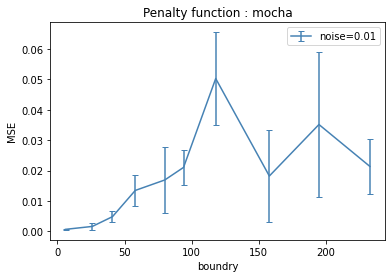

In [75]:
import random
import matplotlib.pyplot as plt
from collections import defaultdict
from joblib import Parallel, delayed
import multiprocessing


PENALTY_FUNCS = ['norm1', 'norm2', 'mocha']

lambda_lasso = 0.05

num_tries = 3
num_cores = multiprocessing.cpu_count()

# K = 2000
K = 1000
sampling_ratio = 0.6
pouts = [0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.4, 0.5, 0.6]
# noises = [0.01, 0.1, 1.0]
noises = [0.01]
colors = ['steelblue', 'darkorange', 'green']


def fun(penalty_func, noise, pout):
    B, weight_vec, true_labels, datapoints, boundry, eigengap = get_sbm_2blocks_data(
        m=10, n=1,
        pin=0.5, 
        pout=pout, 
        noise_sd=noise,
        is_torch_model=False
    )
    
    eigengap = np.round(eigengap, 2)


    E, N = B.shape

    samplingset = random.sample([i for i in range(N)], k=int(sampling_ratio * N))

    _, predicted_w = algorithm_1(K, B, weight_vec, datapoints, true_labels, samplingset, 
                                 lambda_lasso, penalty_func)

    alg1_score = get_algorithm1_w_MSE(datapoints, predicted_w)
    return noise, boundry, eigengap, pout, alg1_score


for penalty_func in PENALTY_FUNCS:
    if penalty_func != 'mocha':
        continue
    print('penalty_func:', penalty_func)
        
    results = Parallel(n_jobs=num_cores)(delayed(fun)(penalty_func, noise, pout) 
                                         for noise in noises 
                                         for pout in pouts for i in range(num_tries))
    pout_mses = defaultdict(list)
    boundries = set()
    pout_boundries = defaultdict(set)
    for noise, boundry, eigengap, pout, alg1_score in results:
        boundries.add(boundry)
        pout_boundries[pout].add(boundry)
        pout_mses[(noise, boundry)].append(alg1_score['total'])


    boundries = sorted(boundries)
    print('pout_boundries', pout_boundries)
    
    for i, noise in enumerate(noises):
        MSEs_mean = {}
        MSEs_std = {}
        for boundry in boundries:
            MSEs_mean[boundry] = np.mean(pout_mses[(noise, boundry)])
            MSEs_std[boundry] = np.std(pout_mses[(noise, boundry)])

        plt.errorbar(list(MSEs_mean.keys()), list(MSEs_mean.values()), yerr=list(MSEs_std.values()), 
                 ecolor=colors[i], capsize=3,
                 label='noise=' + str(noise), c=colors[i])

        print('noise', noise)
        print(' MSEs_mean:', MSEs_mean)
        print(' MSEs_std:', MSEs_std)

    plt.xlabel('boundry')
    plt.ylabel('MSE')
    plt.legend(loc='best')
    plt.title('Penalty function : %s' % penalty_func)
    plt.show()
    plt.close()
    

penalty_func: mocha
pin_eigengaps defaultdict(<class 'set'>, {0.15: {0.19}, 0.1: {0.0}, 0.2: {0.3}, 0.3: {1.05}, 0.4: {2.78}, 0.5: {4.19}, 0.6: {6.33}, 0.7: {9.17}, 0.8: {10.97}, 0.9: {13.81}, 1.0: {20.0}})
noise 0.01
 MSEs_mean: {0.0: 0.03554287381112784, 0.19: 0.029744549060405693, 0.3: 0.024849399838183576, 1.05: 0.0224844300163248, 2.78: 0.010862619185276095, 4.19: 0.019735579501167205, 6.33: 0.011738669874109, 9.17: 0.009068832709286751, 10.97: 0.0029835570381457044, 13.81: 0.004791372239061133, 20.0: 0.003343342992527355}
 MSEs_std: {0.0: 0.022503451125531117, 0.19: 0.03555777422221367, 0.3: 0.01629716176027545, 1.05: 0.008871476240141766, 2.78: 0.009261324620917045, 4.19: 0.010062225541983992, 6.33: 0.007661574739309469, 9.17: 0.005587297142517647, 10.97: 0.001203852514343834, 13.81: 0.002038194713136153, 20.0: 0.0021165609883436933}


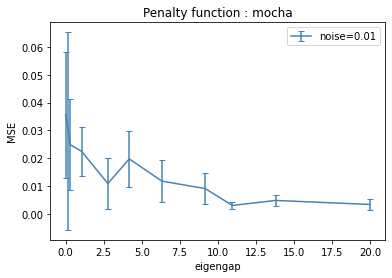

In [76]:
import random
import matplotlib.pyplot as plt
from collections import defaultdict
from joblib import Parallel, delayed
import multiprocessing


PENALTY_FUNCS = ['norm1', 'norm2', 'mocha']

lambda_lasso = 0.05

num_tries = 3
num_cores = multiprocessing.cpu_count()

# K = 2000
K = 1000
sampling_ratio = 0.6
pins = [0.15, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
# noises = [0.01, 0.1, 1.0]
noises = [0.01]
colors = ['steelblue', 'darkorange', 'green']


def fun(penalty_func, noise, pin):
    B, weight_vec, true_labels, datapoints, boundry, eigengap = get_sbm_2blocks_data(
        m=10, n=1,
        pin=pin, 
        pout=0.15, 
        noise_sd=noise,
        is_torch_model=False
    )
    
    eigengap = np.round(eigengap, 2)


    E, N = B.shape

    samplingset = random.sample([i for i in range(N)], k=int(sampling_ratio * N))

    _, predicted_w = algorithm_1(K, B, weight_vec, datapoints, true_labels, samplingset, 
                                 lambda_lasso, penalty_func)

    alg1_score = get_algorithm1_w_MSE(datapoints, predicted_w)
    return noise, boundry, eigengap, pin, alg1_score


for penalty_func in PENALTY_FUNCS:
    if penalty_func != 'mocha':
        continue
    print('penalty_func:', penalty_func)
        
    results = Parallel(n_jobs=num_cores)(delayed(fun)(penalty_func, noise, pin) 
                                         for noise in noises 
                                         for pin in pins for i in range(num_tries))
    pout_mses = defaultdict(list)
    eigengaps = set()
    pout_boundries = defaultdict(set)
    pout_eigengaps = defaultdict(set)
    for noise, boundry, eigengap, pout, alg1_score in results:
        eigengaps.add(eigengap)
        pout_eigengaps[pout].add(eigengap)
        pout_mses[(noise, eigengap)].append(alg1_score['total'])


    eigengaps = sorted(eigengaps)
    print('pin_eigengaps', pout_eigengaps)
    
    for i, noise in enumerate(noises):
        MSEs_mean = {}
        MSEs_std = {}
        for eigengap in eigengaps:
            MSEs_mean[eigengap] = np.mean(pout_mses[(noise, eigengap)])
            MSEs_std[eigengap] = np.std(pout_mses[(noise, eigengap)])

        plt.errorbar(list(MSEs_mean.keys()), list(MSEs_mean.values()), yerr=list(MSEs_std.values()), 
                 ecolor=colors[i], capsize=3,
                 label='noise=' + str(noise), c=colors[i])

        print('noise', noise)
        print(' MSEs_mean:', MSEs_mean)
        print(' MSEs_std:', MSEs_std)

    plt.xlabel('eigengap')
    plt.ylabel('MSE')
    plt.legend(loc='best')
    plt.title('Penalty function : %s' % penalty_func)
    plt.show()
    plt.close()